##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from PIL import Image
import os

import numpy as np

import fnmatch


2022-12-14 06:54:27.053399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 06:54:27.099641: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [3]:
# (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# # Normalize pixel values to be between 0 and 1
# train_images, test_images = train_images / 255.0, test_images / 255.0

# train_images.shape

# test_images.shape

# train_labels.shape


In [4]:
# # Load images into arrays and create labels

# filenames = []

# image_width = 240
# image_height = 320

# # directory
# dir_path = 'Training Set BW 1000 sub'

# N_im = len(fnmatch.filter(os.listdir(dir_path), '*.*'))

# N_pp = len(fnmatch.filter(os.listdir(dir_path), '*perfPersp.*'))
# print(f'Total images: {N_im} | Number of undistorted images: {N_pp} | Number of distorted images: {N_im - N_pp}')


# all_distortion_images = np.zeros((N_im,image_width,image_height)) # array of GS values for images [N x width x height]

# all_distortion_labels = np.zeros(N_im,dtype=int) # array of labels for images denoting if they are distorted. 0 = not distorted, 1 = distored

# all_distortion_values = np.zeros(N_im) # array of distortion coefficients

# filenames = [] # list of filenames

# remove_idx = [] # list of indexes to remove


# # iterate over files in directory
# for kf, filename1 in enumerate(os.listdir(dir_path)):
#     f1 = os.path.join(dir_path, filename1)
#     # check if file is valid
#     if os.path.isfile(f1) and ".jpg" in f1:
#         filenames.append(filename1)
#         # load image
#         img = Image.open(f1)
#         # convert to numpy array
#         img_array = np.asarray(img)/255
#         # print(img_array.shape)
        
#         if img_array.ndim == 2:
#             if img_array.shape[0] == all_distortion_images.shape[1] and img_array.shape[1] == all_distortion_images.shape[2]:
#                 all_distortion_images[kf,:,:] =  img_array.reshape((1,img_array.shape[0],img_array.shape[1])) # reshape to 1 x width x height
#             else:
#                 remove_idx.append(kf)
#         if img_array.ndim == 3:
#             if img_array.shape[0] == all_distortion_images.shape[1] and img_array.shape[1] == all_distortion_images.shape[2] and img_array.shape[2] == all_distortion_images.shape[3]:
#                 all_distortion_images[kf,:,:,:] =  img_array.reshape((1,img_array.shape[0],img_array.shape[1],img_array.shape[2],1)) # reshape to 1 x width x height
#             else:
#                 remove_idx.append(kf)
        
#         # if "perfPersp" not in filename1:
#         if "perfPersp" not in filename1:
#             all_distortion_labels[kf] = 1 # label image as distorted
#             # parse filename to obtain distortion coefficient
#             distortion_value = int(filename1.split(".")[0].split("_")[1]) / 10**int(len(filename1.split(".")[0].split("_")[1]))
#             all_distortion_values[kf] = distortion_value
#         # else, image is not distored
#         else:
#             all_distortion_labels[kf] = 0 # label image as undistorted
#             all_distortion_values[kf] = 0 # distortion coefficient
#     else:
#         remove_idx.append(kf)


# all_distortion_labels = all_distortion_labels.reshape(-1,1) # reshape to 2D array

# all_distortion_values = all_distortion_values.reshape(-1,1) # reshape to 2D array

# # all_distortion_images.shape

# # all_distortion_labels.shape

# # all_distortion_values.shape

# remove_idx



In [5]:
# # split data into train and test data

# np.random.seed(42) # set random seed

# idx = np.random.permutation(all_distortion_images.shape[0]) # randomized permutation of indices

# idx_split = int(0.8*len(all_distortion_images)) # index for the train/test

# idx_train = idx[0:idx_split] # training indices
# idx_test = idx[idx_split:] # test indices

# # print(idx_train)
# # print(idx_test)

# # split all data and labels into training and test sets
# train_images = all_distortion_images[idx_train,:,:] # training images

# test_images = all_distortion_images[idx_test,:,:] # test images

# train_labels = all_distortion_labels[idx_train] # training labels

# test_labels = all_distortion_labels[idx_test] # test labels

# train_values = all_distortion_values[idx_train] # training distortion values

# test_values = all_distortion_values[idx_test] # test distortion values

# # train_filenames = [filenames[idx_train[k1]] for k1 in range(0,len(idx_train))]
# # test_filenames = [filenames[idx_test[k1]] for k1 in range(0,len(idx_test))]

# train_filenames = [filenames[idx] for idx in idx_train]
# test_filenames = [filenames[idx] for idx in idx_test]

# # print(train_labels[:,0].T)

# # print(test_labels[:,0].T)

# # print(train_values[:,0].T)

# # print(test_values[:,0].T)


In [6]:
from Distortion_Functions import load_distortion_data

image_width = 240
image_height = 320

# directory
dir_path = 'Training Set BW 1000 sub'


dist_images, dist_labels, dist_values, dist_filenames = load_distortion_data(dir_path, image_width, image_height)



Total images: 1001 | Number of undistorted images: 501 | Number of distorted images: 500


In [7]:
from Distortion_Functions import dist_train_test_split

split_data = dist_train_test_split(dist_images, dist_labels, dist_values, dist_filenames, 0.8, 42)

idx_train = split_data["idx_train"]
train_images = split_data["train_images"]
train_labels = split_data["train_labels"]
train_values = split_data["train_values"]
train_filenames = split_data["train_filenames"]

idx_test = split_data["idx_test"]
test_images = split_data["test_images"]
test_labels = split_data["test_labels"]
test_values = split_data["test_values"]
test_filenames = split_data["test_filenames"]

split_data.keys()


dict_keys(['idx', 'idx_train', 'idx_test', 'train_images', 'train_labels', 'train_values', 'train_filenames', 'test_images', 'test_labels', 'test_values', 'test_filenames'])

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


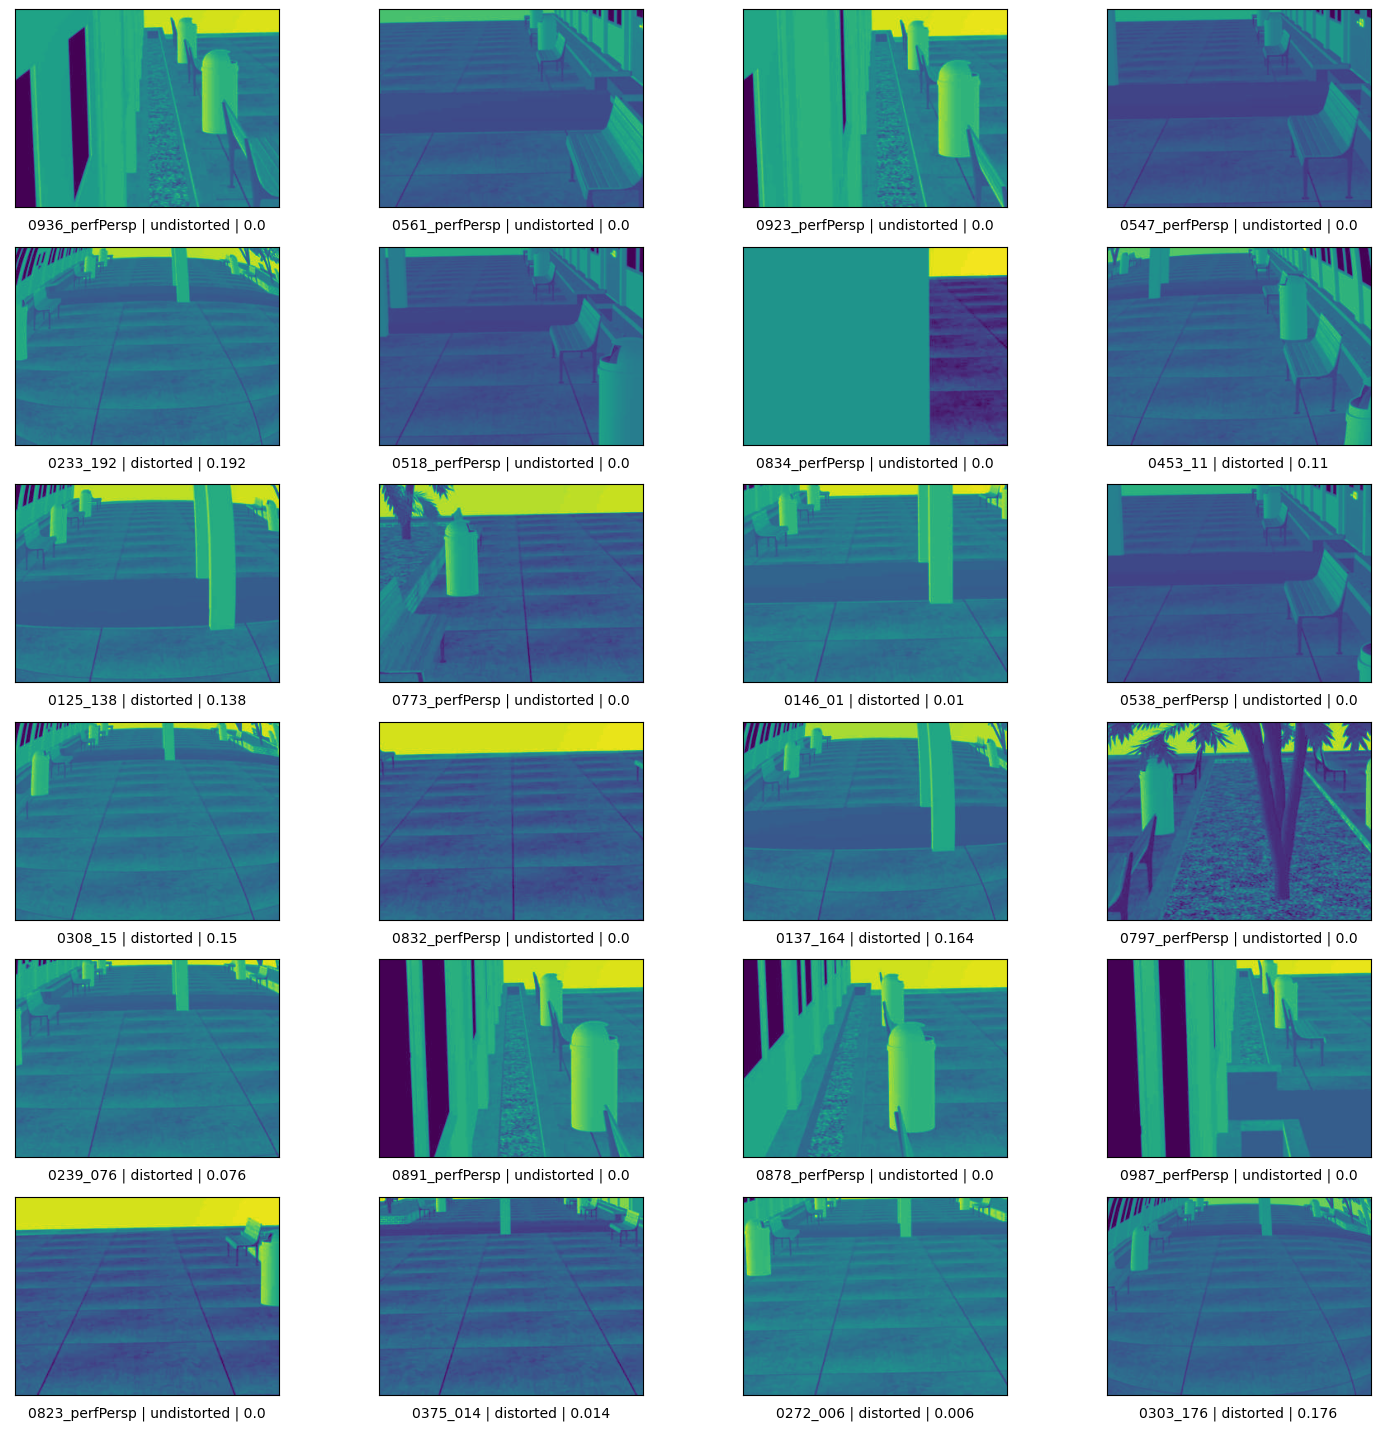

In [8]:
class_names = ['undistorted', 'distorted']

plt.figure(figsize=(18,18))
for k1 in range(0,24):
    plt.subplot(6,4,k1+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[k1])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(f"{dist_filenames[idx_train[k1]].split('.')[0]} | {class_names[train_labels[k1,0]]} | {train_values[k1,0]}")
plt.show()


### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [9]:
# Create first model

model_01 = models.Sequential()
model_01.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dist_images.shape[1], dist_images.shape[2], 1)))
model_01.add(layers.MaxPooling2D((2, 2)))
model_01.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_01.add(layers.MaxPooling2D((2, 2)))
model_01.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_01.add(layers.Flatten())
model_01.add(layers.Dense(64, activation='relu'))
model_01.add(layers.Dense(2, activation='linear'))
# model_01.add(layers.Dense(1, activation='sigmoid'))

model_01.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 318, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 159, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 76, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 272384)            0

2022-12-14 06:54:30.010253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Compile and train first model

# compile model
model_01.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# train model
history = model_01.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))


# model = my_model()
# saver = tf.train.Saver()
# with tf.Session() as sess:
#     sess.run(init_op)
#     for epoch in range(NUM_EPOCHS):
#         for batch in range(NUM_BATCHES):

#             # ... train your model ...

#             if batch % VALIDATION_FREQUENCY == 0:
#                 # Periodically test against a validation set.
#                 error = sess.run(model.error, feed_dict=valid_dict)
#                 if error < min_error:
#                     min_error = error  # store your best error so far
#                     saver.save(sess, MODEL_PATH)  # save the best-performing network so far

# saver.restore(sess, MODEL_PATH)
# test_error = sess.run(model.error, feed_dict=test_dict)



Epoch 1/10
25/25 [==============================] - 17s 659ms/step - loss: 0.7805 - accuracy: 0.6675 - val_loss: 0.3497 - val_accuracy: 0.8806
Epoch 2/10
25/25 [==============================] - 16s 644ms/step - loss: 0.2758 - accuracy: 0.8963 - val_loss: 0.1350 - val_accuracy: 0.9403
Epoch 3/10
25/25 [==============================] - 16s 653ms/step - loss: 0.0612 - accuracy: 0.9800 - val_loss: 0.0306 - val_accuracy: 0.9950
Epoch 4/10
25/25 [==============================] - 16s 658ms/step - loss: 0.0928 - accuracy: 0.9688 - val_loss: 0.0774 - val_accuracy: 0.9701
Epoch 5/10
25/25 [==============================] - 17s 672ms/step - loss: 0.0838 - accuracy: 0.9688 - val_loss: 0.0570 - val_accuracy: 0.9751
Epoch 6/10
25/25 [==============================] - 19s 774ms/step - loss: 0.0188 - accuracy: 0.9912 - val_loss: 0.0487 - val_accuracy: 0.9851
Epoch 7/10
25/25 [==============================] - 19s 782ms/step - loss: 0.0100 - accuracy: 0.9975 - val_loss: 0.0569 - val_accuracy: 0.9900

### Evaluate the model

In [11]:
# dir(history.model.history)

# history.model.history

7/7 - 1s - loss: 0.0337 - accuracy: 0.9900 - 1s/epoch - 181ms/step


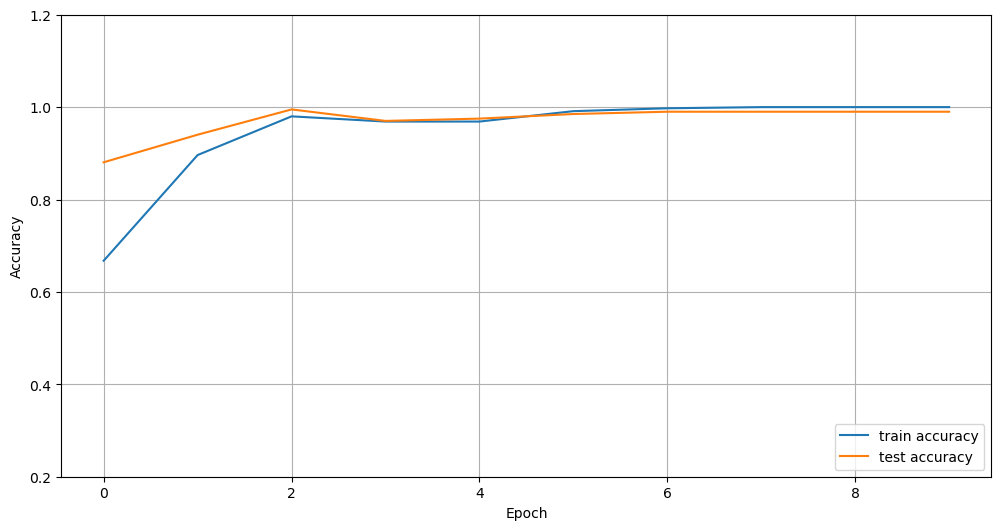

In [12]:
#

fig1 = plt.figure(figsize=(12,6))
# plt.plot(history.epoch,0.6*np.ones(len(history.epoch)),'k--')
# plt.plot(history.epoch,0.7*np.ones(len(history.epoch)),'k--')
# plt.plot(history.epoch,0.8*np.ones(len(history.epoch)),'k--')
# plt.plot(history.epoch,0.9*np.ones(len(history.epoch)),'k--')
# plt.plot(history.epoch,1.0*np.ones(len(history.epoch)),'k--')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1.2])
plt.grid()
plt.legend(loc='lower right')

test_loss, test_acc = model_01.evaluate(test_images, test_labels, verbose=2)


1/1 [==============================] - 0s 81ms/step
Model prediction for image 1:
[  3.996685 -10.889597]
Predicted classes for test image: 0 | undistorted
True class for terst image: 0 | undistorted


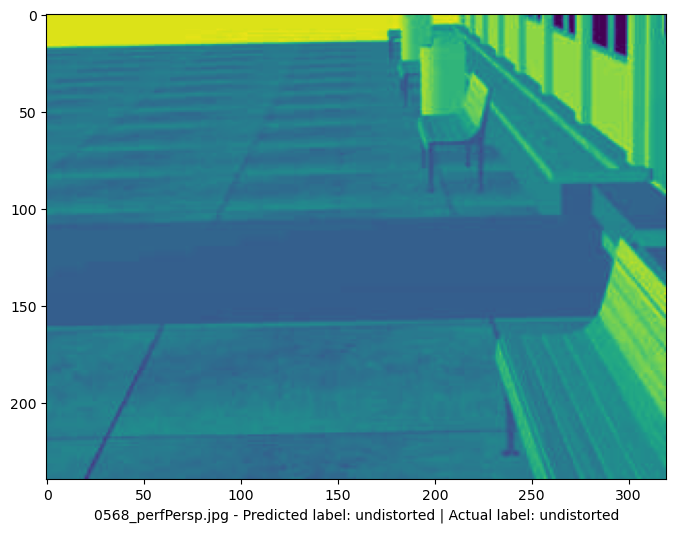

In [13]:
# Look at output of model for single image

kim = 1

prediction = model_01.predict(test_images[kim].reshape(1,image_width,image_height))[0]
print(f"Model prediction for image {kim}:")
print(prediction)

# apply classification using argmax to 0 or 1
predicted_class = np.argmax(prediction)

print(f"Predicted classes for test image: {predicted_class} | {class_names[predicted_class]}")
# print(predicted_class)

print(f"True class for terst image: {test_labels[kim,0]} | {class_names[test_labels[kim,0]]}")
# print(test_labels[kim,0].T)

fig1 = plt.figure(figsize=(8,8))
plt.imshow(test_images[kim])
plt.xlabel(f"{test_filenames[kim]} - Predicted label: {class_names[predicted_class]} | Actual label: {class_names[test_labels[kim,0]]}")
plt.show()

7/7 [==============================] - 1s 193ms/step
Predicted classes for test images:
[0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1
 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1
 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1
 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0
 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1
 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0]
Test image labels:
[0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1
 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1
 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1
 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0
 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1
 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0]
Number of correct predictions out of number of test images: 199 / 201
Model

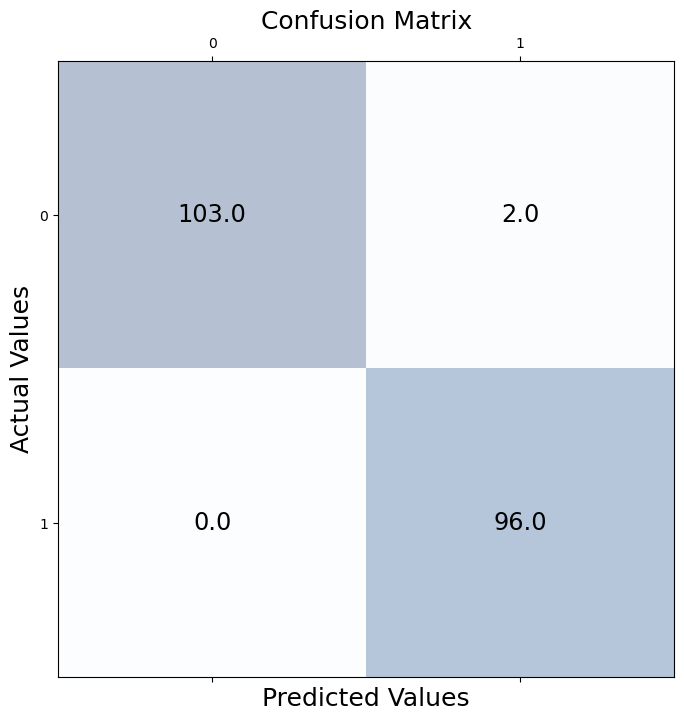

In [14]:
# Validate model accuracy

# model prediction from test_images
prediction = model_01.predict(test_images)
# print(prediction)

# apply classification using argmax to 0 or 1
predicted_class = np.argmax(prediction, axis=1)

print("Predicted classes for test images:")
print(predicted_class)

print("Test image labels:")
print(test_labels[:,0].T)

print(f"Number of correct predictions out of number of test images: {np.sum(predicted_class == test_labels[:,0])} / {len(test_labels)}")
# np.sum(predicted_class == test_labels)

print(f"Model accuracy on test images: {np.sum(predicted_class == test_labels[:,0]) / len(test_labels)}")

# wrong_idx = np.asarray(predicted_class != test_labels[:,0], dtype=int)
# wrong_idx = np.arange(0,len(wrong_idx))[wrong_idx == 1]

wrong_idx = np.arange(0,len(test_images))[(predicted_class != test_labels[:,0])]
print("Indices for erroneous predictions")
print(wrong_idx)
print("Filenames for errorneous predictions")
print(np.array(test_filenames)[wrong_idx])

und_idx = (test_labels[:,0] == 0)
dis_idx = (test_labels[:,0] == 1)

# print(f"True negatives: {np.sum((predicted_class == 0))} / {np.sum((test_labels[:,0] == 0))}")
# print(f"True positives: {np.sum((predicted_class == 1))} / {np.sum((test_labels[:,0] == 1))}")

print(f"True negatives: {np.sum((predicted_class[und_idx] == 0))} / {np.sum((test_labels[:,0] == 0))}")
print(f"True positives: {np.sum((predicted_class[dis_idx] == 1))} / {np.sum((test_labels[:,0] == 1))}")
print(f"False negatives: {np.sum((predicted_class[dis_idx] == 0))} / {np.sum((test_labels[:,0] == 1))}")
print(f"False positives: {np.sum((predicted_class[und_idx] == 1))} / {np.sum((test_labels[:,0] == 0))}")

conf_matrix = np.zeros((2,2))
conf_matrix[0,0] = np.sum((predicted_class[und_idx] == 0))
conf_matrix[0,1] = np.sum((predicted_class[und_idx] == 1))
conf_matrix[1,0] = np.sum((predicted_class[dis_idx] == 0))
conf_matrix[1,1] = np.sum((predicted_class[dis_idx] == 1))

# plot the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for k1 in range(conf_matrix.shape[0]):
    for k2 in range(conf_matrix.shape[1]):
        ax.text(x=k2, y=k1, s=conf_matrix[k1, k2], va='center', ha='center', size='xx-large')

plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Actual Values', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [15]:
# Create second model

model_02 = models.Sequential()
model_02.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(240, 320, 1)))
model_02.add(layers.MaxPooling2D((2, 2)))
model_02.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_02.add(layers.MaxPooling2D((2, 2)))
model_02.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model_02 = models.Sequential()
# model_02.add(layers.Conv2D(32, (6, 6), activation='relu', input_shape=(480, 640, 3)))
# model_02.add(layers.MaxPooling2D((2, 2)))
# model_02.add(layers.Conv2D(64, (6, 6), activation='relu'))
# model_02.add(layers.MaxPooling2D((2, 2)))
# model_02.add(layers.Conv2D(64, (6, 6), activation='relu'))

model_02.add(layers.Flatten())
model_02.add(layers.Dense(64, activation='relu'))
# model_02.add(layers.Dense(2))
model_02.add(layers.Dense(1, activation='sigmoid'))

model_02.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 238, 318, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 119, 159, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 117, 157, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 58, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 76, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 272384)           

In [16]:
# Compile and train second model

# compile model
model_02.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'])

# train model
history = model_02.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))


Epoch 1/10
25/25 [==============================] - 18s 720ms/step - loss: 0.7004 - accuracy: 0.6875 - val_loss: 0.1767 - val_accuracy: 0.9502
Epoch 2/10
25/25 [==============================] - 18s 711ms/step - loss: 0.1389 - accuracy: 0.9463 - val_loss: 0.0413 - val_accuracy: 0.9801
Epoch 3/10
25/25 [==============================] - 17s 671ms/step - loss: 0.0311 - accuracy: 0.9887 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 17s 676ms/step - loss: 0.0091 - accuracy: 0.9975 - val_loss: 0.0145 - val_accuracy: 0.9950
Epoch 5/10
25/25 [==============================] - 18s 717ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 18s 707ms/step - loss: 8.8191e-04 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 18s 708ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 0.

1/1 [==============================] - 0s 58ms/step
Model prediction for image 45:
[0.99994063]
Predicted classes for test image: 0 | undistorted
True class for terst image: 1 | distorted


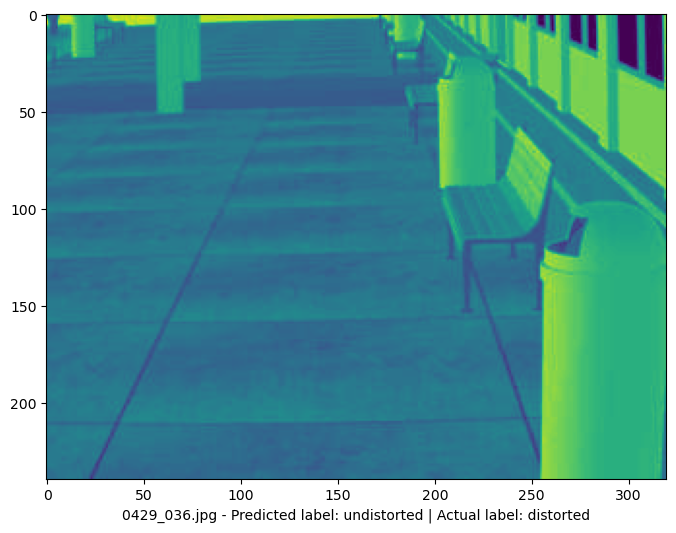

In [17]:
# Look at output of model for single image

kim = 45

prediction = model_02.predict(test_images[kim].reshape(1,image_width,image_height))[0]
print(f"Model prediction for image {kim}:")
print(prediction)

# apply classification using argmax to 0 or 1
predicted_class = np.argmax(prediction)

print(f"Predicted classes for test image: {predicted_class} | {class_names[predicted_class]}")
# print(predicted_class)

print(f"True class for terst image: {test_labels[kim,0]} | {class_names[test_labels[kim,0]]}")
# print(test_labels[kim,0].T)

fig1 = plt.figure(figsize=(8,8))
plt.imshow(test_images[kim])
plt.xlabel(f"{test_filenames[kim]} - Predicted label: {class_names[predicted_class]} | Actual label: {class_names[test_labels[kim,0]]}")
plt.show()

7/7 [==============================] - 1s 186ms/step
Predicted classes for test images:
[0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1
 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1
 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1
 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0
 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1
 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0]
Test image labels:
[0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1
 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1
 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1
 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0
 1 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1
 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0]
Number of correct predictions out of number of test images: 200 / 201
Model

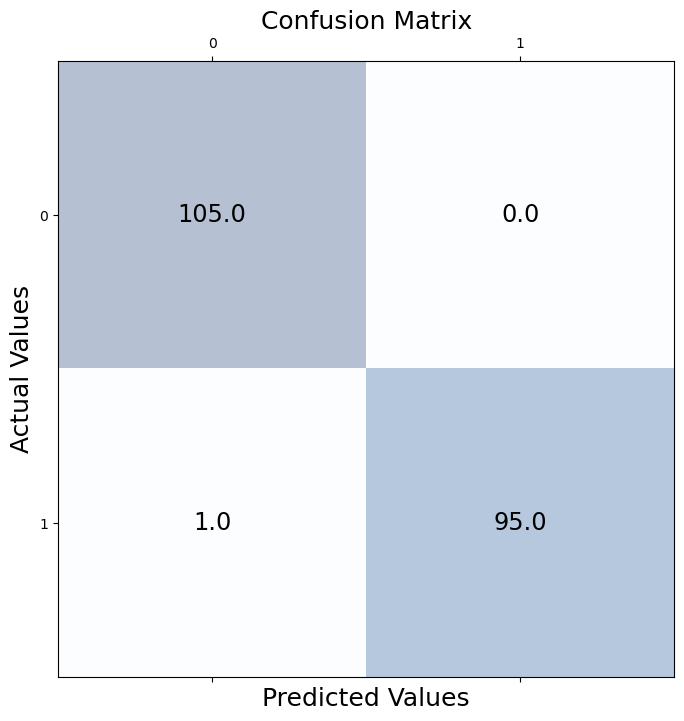

In [18]:
# Validate model accuracy

# model prediction from test_images
prediction = model_02.predict(test_images)
# print(prediction.T)

# apply classification using argmax to 0 or 1
prediction[prediction < 0.5] = 0
prediction[prediction >= 0.5] = 1
predicted_class = prediction[:,0].astype(int)
# predicted_class = np.argmax(prediction, axis=1)

print("Predicted classes for test images:")
print(predicted_class)

print("Test image labels:")
print(test_labels[:,0].T)

print(f"Number of correct predictions out of number of test images: {np.sum(predicted_class == test_labels[:,0])} / {len(test_labels)}")
# np.sum(predicted_class == test_labels)

print(f"Model accuracy on test images: {np.sum(predicted_class == test_labels[:,0]) / len(test_labels)}")

# wrong_idx = np.asarray(predicted_class != test_labels[:,0], dtype=int)
# wrong_idx = np.arange(0,len(wrong_idx))[wrong_idx == 1]

wrong_idx = np.arange(0,len(test_images))[(predicted_class != test_labels[:,0])]
print("Indices for erroneous predictions")
print(wrong_idx)
print("Filenames for errorneous predictions")
print(np.array(test_filenames)[wrong_idx])

und_idx = (test_labels[:,0] == 0)
dis_idx = (test_labels[:,0] == 1)

# print(f"True negatives: {np.sum((predicted_class == 0))} / {np.sum((test_labels[:,0] == 0))}")
# print(f"True positives: {np.sum((predicted_class == 1))} / {np.sum((test_labels[:,0] == 1))}")

print(f"True negatives: {np.sum((predicted_class[und_idx] == 0))} / {np.sum((test_labels[:,0] == 0))}")
print(f"True positives: {np.sum((predicted_class[dis_idx] == 1))} / {np.sum((test_labels[:,0] == 1))}")
print(f"False negatives: {np.sum((predicted_class[dis_idx] == 0))} / {np.sum((test_labels[:,0] == 1))}")
print(f"False positives: {np.sum((predicted_class[und_idx] == 1))} / {np.sum((test_labels[:,0] == 0))}")

conf_matrix = np.zeros((2,2))
conf_matrix[0,0] = np.sum((predicted_class[und_idx] == 0))
conf_matrix[0,1] = np.sum((predicted_class[und_idx] == 1))
conf_matrix[1,0] = np.sum((predicted_class[dis_idx] == 0))
conf_matrix[1,1] = np.sum((predicted_class[dis_idx] == 1))

# plot the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for k1 in range(conf_matrix.shape[0]):
    for k2 in range(conf_matrix.shape[1]):
        ax.text(x=k2, y=k1, s=conf_matrix[k1, k2], va='center', ha='center', size='xx-large')

plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Actual Values', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [19]:
x = np.random.rand(4,3,2)

print(x)

x = np.delete(x, [1, 3], 0)

print(x)

[[[0.98996023 0.32235384]
  [0.80987445 0.25464065]
  [0.68150272 0.76022786]]

 [[0.59563874 0.47157619]
  [0.41184091 0.34886827]
  [0.92952914 0.83061941]]

 [[0.96502691 0.12429722]
  [0.73086748 0.93834046]
  [0.18123307 0.06649627]]

 [[0.74112065 0.57447311]
  [0.84182878 0.13977238]
  [0.79526731 0.20162732]]]
[[[0.98996023 0.32235384]
  [0.80987445 0.25464065]
  [0.68150272 0.76022786]]

 [[0.96502691 0.12429722]
  [0.73086748 0.93834046]
  [0.18123307 0.06649627]]]
